Test porfolio optimization and diversification calculations

In [2]:
import pandas as pd
import datetime
import numpy as np
import pickle
import sklearn
import networkx as nx
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.covariance import GraphicalLassoCV, graphical_lasso, GraphicalLasso
from sklearn.preprocessing import StandardScaler
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.integrate as integrate

# add path to other folders, to import
import sys, os
sys.path.append(os.path.abspath(".."))
from util import fetch_raw_data, avg_degree

In [3]:
import random
ok = [1,2,3]
random.shuffle(ok)
ok

[3, 1, 2]

In [4]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
spectralGraphTopology = importr('spectralGraphTopology')
igraph = importr('igraph')
fingraph = importr('fingraph')
fitHeavyTail = importr('fitHeavyTail')
huge = importr('huge')


Unable to determine R library path: Command '('C:\\PROGRA~1\\R\\R-41~1.3\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.


Change huge package

change huge package

In [5]:
robjects.r('''

library(spectralGraphTopology)

#' @export
#' @import spectralGraphTopology
learn_regular_heavytail_graph <- function(X,
                                          heavy_type = "gaussian", nu = NULL,
                                          w0 = "naive", d = 1,
                                          rho = 1, update_rho = TRUE, maxiter = 10000, reltol = 1e-5,
                                          verbose = TRUE) {
  X <- as.matrix(X)
  # number of nodes
  p <- ncol(X)
  # number of observations
  n <- nrow(X)
  LstarSq <- vector(mode = "list", length = n)
  for (i in 1:n)
    LstarSq[[i]] <- Lstar(X[i, ] %*% t(X[i, ])) / (n-1)
  # w-initialization
  w <- spectralGraphTopology:::w_init(w0, MASS::ginv(cor(X)))
  A0 <- A(w)
  A0 <- A0 / rowSums(A0)
  w <- spectralGraphTopology:::Ainv(A0)
  J <- matrix(1, p, p) / p
  # Theta-initilization
  Lw <- L(w)
  Theta <- Lw
  Y <- matrix(0, p, p)
  y <- rep(0, p)
  # ADMM constants
  mu <- 2
  tau <- 2
  # residual vectors
  primal_lap_residual <- c()
  primal_deg_residual <- c()
  dual_residual <- c()
  # augmented lagrangian vector
  lagrangian <- c()
  if (verbose)
    pb <- progress::progress_bar$new(format = "<:bar> :current/:total  eta: :eta",
                                     total = maxiter, clear = FALSE, width = 80)
  elapsed_time <- c()
  start_time <- proc.time()[3]
  for (i in 1:maxiter) {
    # update w
    LstarLw <- Lstar(Lw)
    DstarDw <- Dstar(diag(Lw))
    LstarSweighted <- rep(0, .5*p*(p-1))
    if (heavy_type == "student") {
      for (q in 1:n)
        LstarSweighted <- LstarSweighted + LstarSq[[q]] * compute_student_weights(w, LstarSq[[q]], p, nu)
    } else if(heavy_type == "gaussian") {
      for (q in 1:n)
        LstarSweighted <- LstarSweighted + LstarSq[[q]]
    }
    grad <- LstarSweighted - Lstar(rho * Theta + Y) + Dstar(y - rho * d) + rho * (LstarLw + DstarDw)
    eta <- 1 / (2*rho * (2*p - 1))
    wi <- w - eta * grad
    wi[wi < 0] <- 0
    Lwi <- L(wi)
    # update Theta
    eig <- eigen(rho * (Lwi + J) - Y, symmetric = TRUE)
    V <- eig$vectors
    gamma <- eig$values
    Thetai <- V %*% diag((gamma + sqrt(gamma^2 + 4 * rho)) / (2 * rho)) %*% t(V) - J
    # update Y
    R1 <- Thetai - Lwi
    Y <- Y + rho * R1
    # update y
    R2 <- diag(Lwi) - d
    #y <- y + rho * R2
    # compute primal, dual residuals, & lagrangian
    primal_lap_residual <- c(primal_lap_residual, norm(R1, "F"))
    primal_deg_residual <- c(primal_deg_residual, norm(R2, "2"))
    dual_residual <- c(dual_residual, rho*norm(Lstar(Theta - Thetai), "2"))
    lagrangian <- c(lagrangian, compute_augmented_lagrangian_ht(wi, LstarSq, Thetai, J, Y, y, d, heavy_type, n, p, rho, nu))
    # update rho
    if (update_rho) {
      s <- rho * norm(Lstar(Theta - Thetai), "2")
      r <- norm(R1, "F")
      if (r > mu * s)
        rho <- rho * tau
      else if (s > mu * r)
        rho <- rho / tau
    }
    if (verbose)
      pb$tick()
    has_converged <- (norm(Lw - Lwi, 'F') / norm(Lw, 'F') < reltol) && (i > 1)
    elapsed_time <- c(elapsed_time, proc.time()[3] - start_time)
    if (has_converged)
      break
    w <- wi
    Lw <- Lwi
    Theta <- Thetai
  }
  results <- list(laplacian = L(wi),
                  adjacency = A(wi),
                  theta = Thetai,
                  maxiter = i,
                  convergence = has_converged,
                  primal_lap_residual = primal_lap_residual,
                  primal_deg_residual = primal_deg_residual,
                  dual_residual = dual_residual,
                  lagrangian = lagrangian,
                  elapsed_time = elapsed_time)
  return(results)
}

compute_student_weights <- function(w, LstarSq, p, nu) {
  return((p + nu) / (sum(w * LstarSq) + nu))
}

compute_augmented_lagrangian_ht <- function(w, LstarSq, Theta, J, Y, y, d, heavy_type, n, p, rho, nu) {
  eig <- eigen(Theta + J, symmetric = TRUE, only.values = TRUE)$values
  Lw <- L(w)
  Dw <- diag(Lw)
  u_func <- 0
  if (heavy_type == "student") {
    for (q in 1:n)
      u_func <- u_func + (p + nu) * log(1 + n * sum(w * LstarSq[[q]]) / nu)
  } else if (heavy_type == "gaussian"){
    for (q in 1:n)
      u_func <- u_func + sum(n * w * LstarSq[[q]])
  }
  u_func <- u_func / n
  return(u_func - sum(log(eig)) + sum(y * (Dw - d)) + sum(diag(Y %*% (Theta - Lw)))
         + .5 * rho * (norm(Dw - d, "2")^2 + norm(Lw - Theta, "F")^2))
}

''')



robjects.r('''

library(huge)

huge.glasso = function(x, scale = FALSE, lambda = NULL, lambda.min.ratio = NULL, nlambda = NULL, scr = NULL, cov.output = FALSE, verbose = TRUE){

  gcinfo(FALSE)
  n = nrow(x)
  d = ncol(x)
  cov.input = isSymmetric(x)
  if(cov.input)
  {
    if(verbose) cat("The input is identified as the covariance matrix.\n")
    S = x
  }
  else
  {
    if(scale){
      print("SCALE")
      x = scale(x)
    S = cor(x)
    }else{
    print("my_method")
    S = cov(x)
    }

  }
  rm(x)
  gc()
  if(is.null(scr)) scr = FALSE
  if(!is.null(lambda)) nlambda = length(lambda)
  if(is.null(lambda))
  {
    if(is.null(nlambda))
      nlambda = 10
    if(is.null(lambda.min.ratio))
      lambda.min.ratio = 0.1
    lambda.max = max(max(S-diag(d)),-min(S-diag(d)))
    lambda.min = lambda.min.ratio*lambda.max
    lambda = exp(seq(log(lambda.max), log(lambda.min), length = nlambda))
  }

  fit = .Call("_huge_hugeglasso",S,lambda,scr,verbose,cov.output,PACKAGE="huge")

  fit$scr = scr
  fit$lambda = lambda
  fit$cov.input = cov.input
  fit$cov.output = cov.output

  rm(S)
  gc()
  if(verbose){
       cat("\nConducting the graphical lasso (glasso)....done.                                          \r")
       cat("\n")
      flush.console()
  }
  return(fit)
}

huge = function(x, scale = scale, lambda = NULL, nlambda = NULL, lambda.min.ratio = NULL, method = "mb", scr = NULL, scr.num = NULL, cov.output = FALSE, sym = "or", verbose = TRUE)
{
	gcinfo(FALSE)
	est = list()
	est$method = method

	if(method == "ct")
	{
		fit = huge.ct(x, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, lambda = lambda, verbose = verbose)
		est$path = fit$path
		est$lambda = fit$lambda
		est$sparsity = fit$sparsity
		est$cov.input = fit$cov.input
		rm(fit)
		gc()
	}

	if(method == "mb")
	{
		fit = huge.mb(x, lambda = lambda, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, scr = scr, scr.num = scr.num, sym = sym, verbose = verbose)
		est$path = fit$path
		est$beta = fit$beta
		est$lambda = fit$lambda
		est$sparsity = fit$sparsity
		est$df = fit$df
		est$idx_mat = fit$idx_mat
		est$sym = sym
		est$scr = fit$scr
		est$cov.input = fit$cov.input
		rm(fit,sym)
		gc()
	}


	if(method == "glasso")
	{
		fit = huge.glasso(x, scale = scale, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, lambda = lambda, scr = scr, cov.output = cov.output, verbose = verbose)
		est$path = fit$path
		est$lambda = fit$lambda
		est$icov = fit$icov
		est$df = fit$df
		est$sparsity = fit$sparsity
		est$loglik = fit$loglik
		if(cov.output)
			est$cov = fit$cov
		est$cov.input = fit$cov.input
		est$cov.output = fit$cov.output
		est$scr = fit$scr
		rm(fit)
		gc()
	}

	if(method == "tiger")
	{
	  fit = huge.tiger(x, lambda = lambda, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, sym = sym, verbose = verbose)
	  est$path = fit$path
	  est$lambda = fit$lambda
	  est$sparsity = fit$sparsity
	  est$df = fit$df
	  est$idx_mat = fit$idx_mat
	  est$sym = sym
	  est$scr = fit$scr
	  est$cov.input = fit$cov.input
	  est$icov = fit$icov;
	  rm(fit,sym)
	  gc()
	}

	est$data = x

	rm(x,scr,lambda,lambda.min.ratio,nlambda,cov.output,verbose)
	gc()
	class(est) = "huge"
	return(est)
}

my_huge <- function(X, gamma = 0.1, lamda = exp(seq(log(1e-3), log(1e-7), length = 50)),scale = FALSE){

    out.glasso = huge(X, scale = scale, lambda = lamda, method = "glasso")
    return(huge.select(out.glasso, criterion = "ebic",ebic.gamma = 0.1 ))


}



''')

my_huge = robjects.globalenv["my_huge"]

Load data

In [6]:
return_pivot, esg_pivot, sector_classification = fetch_raw_data("C:/Users/User/Code/MMD_Graph_Diversification/")
# esg smoothed stock
with open("../data/tidy/gp_esg_stock_data_frame.pkl", "rb") as input_file:
   gp_esg_stock_data_frame = pickle.load(input_file)


2014-10-01 00:00:00
2022-02-01 00:00:00


# Port opt test

diversification functions

In [6]:
def div_ratio(w, cov):
  # numerator is perfect correlation
  # denom is portfolio risk
  return np.inner(w, np.sqrt(np.diag(cov)))/np.sqrt(np.dot(w, cov).dot(w))

def var_div_ratio(w,data, q = 0.95):
  # w weights
  # d = data

  ind_var = []
  for col in range(data.shape[1]):
      ind_var.append(np.quantile(-data[:,col], q))

  port_var = np.quantile(np.dot(-data, w), q)

  return port_var/np.inner(ind_var,w)

def fix_weight(w:np.array):

    if np.sum(w[w <0]) <-0.3:

        # fix negative
        w[w <0] = 0.3*w[w <0]/np.abs(np.sum(w[w <0]))
        w[w >=0] = 1.3*w[w >=0]/np.abs(np.sum(w[w >=0]))

    return w

def omega(x, level = 0):
  ecdf = ECDF(x)  
  numerator = integrate.quad(lambda x: 1-ecdf(x), level, np.inf, limit = 10000)
  denominator = integrate.quad(ecdf, -np.inf, level, limit = 10000)
  if denominator[0] == 0.0:
    return 10
  else:
    return numerator[0]/denominator[0]

def sharpe(mu, sigma, r_f = 0):

  return (mu-r_f)/sigma

def sortino(mu,x, r_f = 0):

  x_above = x.copy()
  x_above[x_above > r_f] = r_f

  return (mu -r_f)/(np.sqrt(np.mean(x_above ** 2)))

def beta(X_port, X_index):
  return np.cov(X_port,X_index)[0,1]/np.var(X_index)

def treynor(mu, beta, r_f = 0):
  return (mu-r_f)/beta

def max_drawdown(X_port):
  x = np.cumprod(np.exp(X_port))
  return np.min((x/np.array(pd.DataFrame(x).cummax().iloc[:,0])-1))

def portfolio(S,precision_matrix, mu, stock_split_i, type):

  if type == 'uniform':
      w = np.ones(S.shape[1])/S.shape[1]
      mu_p = np.mean(np.dot(stock_split_i, w))
      var_p = np.dot(w,S).dot(w)
  elif type == 'sharpe':
      w = np.dot(precision_matrix, mu)/np.dot(np.ones(S.shape[0]), precision_matrix).dot(mu) 
      w = fix_weight(w)
      mu_p = np.mean(np.dot(stock_split_i, w))
      var_p = np.dot(w,S).dot(w)
  elif type == 'gmv':
      w = np.dot(precision_matrix, np.ones(S.shape[0]))/np.dot(np.ones(S.shape[0]), precision_matrix).dot(np.ones(S.shape[0])) 
      w = fix_weight(w)
      mu_p = np.mean(np.dot(stock_split_i, w))
      var_p = np.dot(w,S).dot(w)


  return w, mu_p, var_p 



Estimate the correlation for some sector using various methods. Look at the weights, diversification for different methods

In [7]:
# esg smoothed stock
gp_esg_stock = pd.read_pickle('../data/tidy/gp_esg_stock_data_frame.pkl')

In [8]:
def get_index(tick):
    """
    Function that takes the sp500 index from yahoo
    """
    
    import requests
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    # ESG historical data (only changes yearly)
    url_esg = f"https://query1.finance.yahoo.com/v7/finance/spark?symbols={tick}&range=10y&interval=1d&indicators=close&includeTimestamps=false&includePrePost=false&corsDomain=finance.yahoo.com&.tsrc=finance"
    response = requests.get(url_esg, headers=headers)
    if response.ok:
        sp500 = pd.DataFrame({'date':pd.to_datetime(response.json()['spark']['result'][0]['response'][0]['timestamp'], unit= 's'),
                              'price':response.json()['spark']['result'][0]['response'][0]['indicators']['quote'][0]['close']})
    
    else:
        print("Empty data frame")
        sp500 = pd.DataFrame()



    return sp500

sp500 = get_index('^GSPC')
sp500['date'] = pd.to_datetime(sp500['date']).dt.date
sp500['return'] = 1 + sp500['price'].pct_change()
sp500['log_return'] = np.log(sp500['price']).diff()
sp500 = sp500.iloc[:,:].dropna(axis= 0)



In [9]:
print(ok)

[2, 3, 1]


In [10]:

sector = 'Energy'
rolling_window_size = 300
time_i = 300
transform = 'nonparanormal'
scale = False

if scale:
    lamda = np.exp(np.linspace(start = np.log(1e-1), stop = np.log(1e-4) ,num =80))
else:
    lamda = np.exp(np.linspace(start = np.log(1e-3), stop = np.log(1e-7) ,num =80))

cov_div_list= []
var_div_list= []
sharpe_list = []
omega_list = []
sortino_list = []
beta_list = []
treynor_list = []
dates = []
Gs1 = []
Gs2 = []
for time_i in tqdm.tqdm(range(rolling_window_size+560*2, rolling_window_size + 560*2+2,2)):

    normal_div_gmv_dict = {}
    var_div_gmv_dict = {}

    assets = sum(sector_classification.values(), [])# np.concatenate([sector_classification[sector] for sector in [sector]])
    current_returns = return_pivot.loc[:,np.isin(return_pivot.columns,assets)].iloc[(time_i - rolling_window_size):time_i]
    all_stocks_in_sector = assets.copy() #sector_classification[sector]

    stocks_in_sector = current_returns.columns[np.isin(current_returns.columns,all_stocks_in_sector)]
    esg_stocks_in_sector = gp_esg_stock.columns[np.isin(gp_esg_stock.columns,all_stocks_in_sector)]

    stocks_considered = np.array(stocks_in_sector.intersection(esg_stocks_in_sector))

    # get esg scores of the stocks for the current iteration
    esg_i = np.array(gp_esg_stock[stocks_considered].iloc[time_i])

    # get snp500 index for current iteration, used in  
    snp500_i = np.array(sp500.loc[np.isin(sp500.date,current_returns.index), 'log_return'])
    # order stocks
    stocks_ordered_i = np.array(stocks_considered[np.argsort(esg_i)])
    stocks_indexes = np.array(range(len(stocks_considered)))
    stocks_index = np.array_split(stocks_indexes, 3)[0]

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()

    stock_split_i = np.array(current_returns)

    if transform is None:
        stock_split_i = np.array(return_pivot[stocks_ordered_i[stocks_index]].iloc[(time_i - rolling_window_size):time_i])
    elif transform == 'nonparanormal':
        stock_split_i =return_pivot[stocks_ordered_i[stocks_index]].iloc[(time_i - rolling_window_size):time_i]
        mu_tmp = np.array(stock_split_i.mean())
        S_tmp = np.array(stock_split_i.cov())
        stock_split_i = huge.huge_npn(np.array(stock_split_i) , npn_func="truncation")
        # convert to correct scale again
        stock_split_i = (stock_split_i*np.sqrt(np.diag(S_tmp)) + mu_tmp)
    else:
        raise ValueError(f"No transform called {transform}")

    var = np.diag(np.cov(stock_split_i.T))

    lamda = np.exp(np.linspace(start = np.log(1e-3), stop = np.log(1e-5), num = 50)) # np.exp(np.linspace(start = np.log(1e-1), stop = np.log(1e-6) ,num =20))
    nlambda = len(lamda)
    out_select = my_huge(stock_split_i, gamma = 0.5, lamda = lamda, scale = scale)
    out_select = dict(zip(out_select.names, list(out_select)))
    where_optimal = int(np.where(out_select['opt.lambda'][0] == out_select['lambda'])[0][0])
    if (where_optimal == nlambda-1) or (where_optimal == 0):
        print(f"Warning optimal graph is last or first regularization parameter, namely param no. {where_optimal} {out_select['lambda'][where_optimal]}...Will extend grid \n")
        if where_optimal == nlambda-1:
            # need to lower regularization
            lamda = np.exp(np.linspace(start = np.log(lamda[-1])+1, stop = np.log(lamda[-1]) -5, num = 20))
        else:
            lamda = np.exp(np.linspace(start = np.log(lamda[0])+3, stop = np.log(lamda[0])-1, num = 20))

        out_select = my_huge(stock_split_i, gamma = 0.01, lamda = lamda, scale = scale)
        out_select = dict(zip(out_select.names, list(out_select)))
        where_optimal = int(np.where(out_select['opt.lambda'][0] == out_select['lambda'])[0][0])




    # S = np.linalg.inv(precision_matrix)
    # if scale:
    #     S = np.dot(np.diag(np.sqrt(var)), S).dot(np.diag(np.sqrt(var)))

    # mu = np.mean(stock_split_i, 0)
    # port_type = 'sharpe'
    # w, mu_p, var_p = portfolio(S, np.linalg.inv(S), mu, np.array(stock_split_i), port_type)
    # r_p = np.dot(np.array(stock_split_i),w)
    # print(np.sum(r_p <0))
    # cov_div_list.append(div_ratio(w,S))
    # var_div_list.append(var_div_ratio(w,np.array(stock_split_i)))
    # sharpe_list.append(sharpe(mu_p, np.sqrt(var_p)))
    # omega_list.append(omega(r_p))
    # sortino_list.append(sortino(mu_p, r_p))

    # beta_p = beta(r_p, snp500_i)
    # beta_list.append(beta_p)
    # treynor_list.append(treynor(mu_p, beta_p))

    dates.append(current_returns.index[-1])
    print(dates)

  0%|          | 0/1 [00:00<?, ?it/s]

Conducting nonparanormal (npn) transformation via truncated ECDF....done.
[1] "my_method"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 2%4%6%7%9%12%14%16%18%19%21%24%26%28%30%31%34%36%38%40%42%43%46%48%50%52%54%56%58%60%62%64%65%68%70%72%74%76%78%80%82%84%86%88%90%92%94%96%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


100%|██████████| 1/1 [00:04<00:00,  4.44s/it]

[datetime.date(2020, 4, 23)]


(array([11., 17., 29., 42., 50., 51., 42., 29., 17., 12.]),
 array([-0.06676508, -0.05355078, -0.04033648, -0.02712219, -0.01390789,
        -0.00069359,  0.01252071,  0.02573501,  0.0389493 ,  0.0521636 ,
         0.0653779 ]),
 <BarContainer object of 10 artists>)

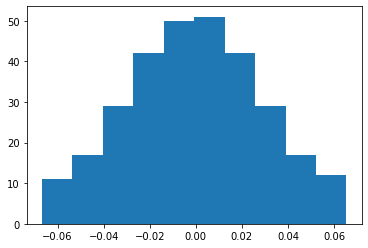

In [17]:
plt.hist(stock_split_i[:,0])

In [12]:
gp_esg_stock[stocks_ordered_i[stocks_index]].loc[gp_esg_stock.index == return_pivot.index[0]].mean(axis = 1)[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [17]:
return_pivot.index[-1]

datetime.date(2022, 4, 29)

In [19]:
gp_esg_stock.index[-1]

datetime.date(2022, 2, 1)

In [14]:
gp_esg_stock[stocks_ordered_i[stocks_index]]

,CBRE,REG,MHK,RHI,CDW,APD,LKQ,IPGP,VFC,BBY,...,NVR,MAA,URI,PKI,QCOM,UNP,EW,CNC,ROL,IBM
date,,,,,,,,,,,,,,,,,,,,,
2014-10-01,7.626279,7.695571,17.820820,13.065179,10.688725,13.460685,12.096235,14.588271,9.594086,19.246564,...,21.278765,18.271386,15.807149,29.724458,19.223113,24.689454,10.215798,23.758275,21.831230,17.016002
2014-10-02,7.625656,7.689380,17.826794,13.072157,10.688908,13.477965,12.098990,14.593829,9.592718,19.248353,...,21.288914,18.270901,15.716127,29.748286,19.230649,24.684963,10.206770,23.760778,21.835681,17.020032
2014-10-03,7.625034,7.683857,17.832492,13.078808,10.689093,13.495299,12.101864,14.598689,9.591413,19.250104,...,21.297436,18.270415,15.622615,29.772077,19.238458,24.680222,10.198179,23.763300,21.839940,17.024282
2014-10-04,7.624412,7.678959,17.837914,13.085137,10.689280,13.512668,12.104864,14.602893,9.590168,19.251816,...,21.304560,18.269928,15.526841,29.795819,19.246523,24.675226,10.190023,23.765842,21.844014,17.028776
2014-10-05,7.623790,7.674645,17.843060,13.091146,10.689469,13.530052,12.107998,14.606483,9.588980,19.253490,...,21.310494,18.269441,15.429028,29.819495,19.254829,24.669975,10.182298,23.768405,21.847907,17.033538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28,7.004315,10.942855,13.698534,9.468503,9.170670,10.849435,12.908252,11.918381,12.638413,14.341352,...,20.621179,14.715604,18.244268,18.242608,18.329121,25.214660,19.359224,22.702416,20.214220,14.792461
2022-01-29,7.006733,10.941767,13.697824,9.471796,9.174621,10.849196,12.904503,11.918364,12.633110,14.343829,...,20.623677,14.692240,18.248369,18.250195,18.329728,25.208230,19.358762,22.704793,20.214583,14.801228
2022-01-30,7.009212,10.939777,13.697071,9.475268,9.178670,10.849016,12.900803,11.918800,12.627543,14.346284,...,20.625532,14.669070,18.252254,18.257831,18.330563,25.201702,19.358216,22.707194,20.214958,14.810177


In [21]:
nx.density(nx.from_numpy_array(out_select['opt.icov']))

0.07061952132374667

In [42]:
nx.from_numpy_array(out_select['icov'][where_optimal+1]).degree(weight = 'weight')

DegreeView({0: 4665.675619695785, 1: 5749.602300482882, 2: 5947.642242802639, 3: 3161.057805140209, 4: 3782.151900501318, 5: 6362.487939899434, 6: 4100.363760137533, 7: 7022.483423914078, 8: 1473.562918484742, 9: 4361.794594398869, 10: -960.7429912528037, 11: 6733.562201447954, 12: 158.46658962190963, 13: 6709.9765697684015, 14: 2688.1332583180856, 15: 6144.021821013679, 16: 2457.895665900319, 17: 847.2035422936752, 18: 1321.4909330489545, 19: 7599.2119747157285, 20: 5504.637003669222, 21: 4787.201410984965, 22: 3559.9193155715093, 23: 5667.959115938015, 24: 5669.619697750259, 25: 5208.821194100789, 26: 3640.223912188624, 27: 6026.141836485722, 28: 2837.782181595957, 29: 3810.719430300894, 30: 5047.203393003874, 31: 3324.556695680377, 32: 4277.570391720472, 33: 6522.191957518933, 34: 7066.094655581002, 35: 6857.817379281497, 36: 7346.642696578987, 37: 6100.5825592062565, 38: 2420.9901417608335, 39: 3828.4175359566307, 40: 6192.730648021087, 41: 6103.252377996845, 42: 7038.649608845514,

In [15]:
out_select['lambda'][where_optimal+1]

6.951927961775612e-05

In [12]:
out_select['lambda']

array([1.00000000e-01, 5.45559478e-02, 2.97635144e-02, 1.62377674e-02,
       8.85866790e-03, 4.83293024e-03, 2.63665090e-03, 1.43844989e-03,
       7.84759970e-04, 4.28133240e-04, 2.33572147e-04, 1.27427499e-04,
       6.95192796e-05, 3.79269019e-05, 2.06913808e-05, 1.12883789e-05,
       6.15848211e-06, 3.35981829e-06, 1.83298071e-06, 1.00000000e-06])

In [11]:
print(out_select['lambda'])
out_select['opt.lambda']

[1.00000000e-01 5.45559478e-02 2.97635144e-02 1.62377674e-02
 8.85866790e-03 4.83293024e-03 2.63665090e-03 1.43844989e-03
 7.84759970e-04 4.28133240e-04 2.33572147e-04 1.27427499e-04
 6.95192796e-05 3.79269019e-05 2.06913808e-05 1.12883789e-05
 6.15848211e-06 3.35981829e-06 1.83298071e-06 1.00000000e-06]


array([0.00012743])

<AxesSubplot:>

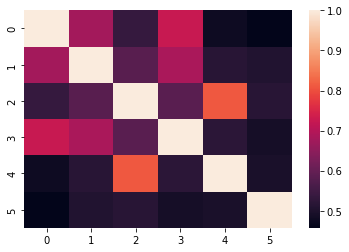

In [29]:
sns.heatmap(np.linalg.inv(precision_matrix2))

<AxesSubplot:>

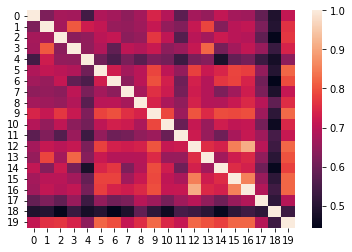

In [55]:
S = np.linalg.inv(precision_matrix)
sns.heatmap(np.dot(np.diag(1/np.sqrt(np.diag(S))), S).dot(np.diag(1/np.sqrt(np.diag(S)))))

In [59]:
precision_matrix[2,:]

array([ -423.49178685,   -60.66050509,  5396.98556097,    -0.        ,
       -1433.34120222,    -0.        ,  -321.56713707,    94.4090684 ,
          -0.        ,  -846.08351452,  -365.1208971 ,   272.10761592,
          -0.        ,    -0.        ,  -598.56170354,    -0.        ,
          84.90097813,    -0.        ,   107.22368183, -1082.72252275])

: 

In [58]:
precision_matrix2[2,:]

array([-0.29742583, -0.04237584,  3.23280618, -0.        , -0.73086486,
       -0.        , -0.23910437,  0.07432087, -0.        , -0.60488016,
       -0.24633137,  0.16425585, -0.        , -0.        , -0.5434876 ,
       -0.        ,  0.01943389,  0.05006725,  0.07202768, -0.73348208])

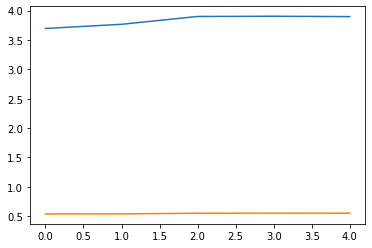

In [50]:
plt.plot([avg_degree(Gs1[j], 'weight')for j in range(len(Gs1))])
plt.plot([avg_degree(Gs2[j], 'weight')/10000  for j in range(len(Gs1))])

C:\Users\User\AppData\Local\Temp\ipykernel_27608\1013852479.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  plt.plot([avg_degree(nx.from_numpy_array(np.abs(nx.adjacency_matrix(Gs1[j]))), 'weight')for j in range(len(Gs1))])
C:\Users\User\AppData\Local\Temp\ipykernel_27608\1013852479.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  plt.plot([avg_degree(nx.from_numpy_array(np.abs(nx.adjacency_matrix(Gs2[j]))), 'weight')/10000  for j in range(len(Gs1))])


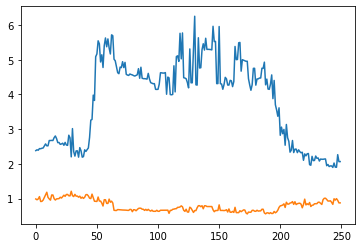

In [37]:
plt.plot([avg_degree(nx.from_numpy_array(np.abs(nx.adjacency_matrix(Gs1[j]))), 'weight')for j in range(len(Gs1))])
plt.plot([avg_degree(nx.from_numpy_array(np.abs(nx.adjacency_matrix(Gs2[j]))), 'weight')/10000  for j in range(len(Gs1))])

0.7052631578947368

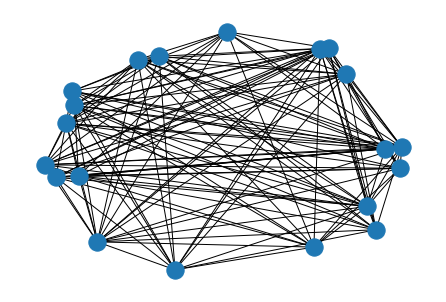

In [10]:
ok = out_select['opt.icov'].copy()
np.fill_diagonal(ok,0)
G = nx.from_numpy_array(ok)
nx.draw(G)
nx.density(G)


In [21]:
mu_tmp = np.array(current_returns.mean())
S_tmp = np.array(current_returns.cov())

In [32]:
X_npn = huge.huge_npn(np.array(current_returns), npn_func="truncation")
X_npn = X_npn*np.sqrt(np.diag(S_tmp)) + mu_tmp

Conducting nonparanormal (npn) transformation via truncated ECDF....done.


In [24]:
mu_tmp[:5]

array([ 0.0004737 , -0.00022377, -0.00052539,  0.00090408,  0.00073074])

In [25]:
np.mean(X_npn,axis = 0)[:5]

array([ 0.0004744 , -0.00022268, -0.00052373,  0.00090491,  0.00073185])

In [33]:
np.cov(X_npn.T)[0,:5]

array([9.33469449e-05, 6.14194499e-05, 6.86942998e-05, 5.57857017e-05,
       6.51795963e-05])

In [28]:
S[0,:5]

array([9.33469449e-05, 5.68660533e-05, 6.45060222e-05, 5.64167511e-05,
       6.14557547e-05])

In [37]:
{key: [value] for key, value in enumerate(mu_tmp)}

{0: [0.0004737012841330376],
 1: [-0.00022377177541145612],
 2: [-0.0005253880290840954],
 3: [0.0009040751511080297],
 4: [0.0007307390789730359],
 5: [-0.0008431321542687523],
 6: [-0.00030275204203270706],
 7: [0.0009980883841116091],
 8: [0.00015507661259434768],
 9: [-0.00031716066489135484],
 10: [0.0011482143116914433],
 11: [-0.001846499650183826],
 12: [-0.000995689001165598],
 13: [-0.0005267291964117226],
 14: [-0.00020392630532722344],
 15: [-0.0001969452008104051],
 16: [0.0007481404263371586],
 17: [6.473795440339173e-05],
 18: [0.0003620516644533261],
 19: [-6.737136220569026e-05],
 20: [0.0006522168493763073],
 21: [0.0005525519540910233],
 22: [-0.0003496093878891137],
 23: [0.0016084400396899005],
 24: [0.0006848362087262835],
 25: [0.00028002633833282823],
 26: [0.00022136139079475574],
 27: [-0.0014250002780654843],
 28: [0.0002928350234575944],
 29: [-0.0009738167620754787],
 30: [-0.000628731209504137],
 31: [0.001537015042075528],
 32: [0.0002408883797303719],
 3

(array([11., 17., 29., 42., 50., 51., 42., 29., 17., 12.]),
 array([0.00026408, 0.000306  , 0.00034793, 0.00038985, 0.00043178,
        0.0004737 , 0.00051563, 0.00055755, 0.00059947, 0.0006414 ,
        0.00068332]),
 <BarContainer object of 10 artists>)

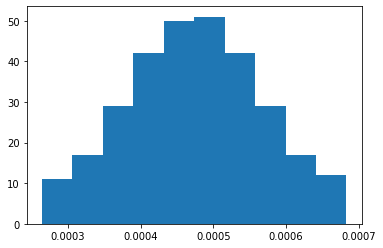

In [861]:
plt.hist(X_npn[:,0])

(array([  2.,   1.,   4.,  11.,  31.,  94., 108.,  38.,   7.,   4.]),
 array([-0.04554511, -0.03786306, -0.03018101, -0.02249896, -0.01481691,
        -0.00713486,  0.00054719,  0.00822924,  0.01591128,  0.02359333,
         0.03127538]),
 <BarContainer object of 10 artists>)

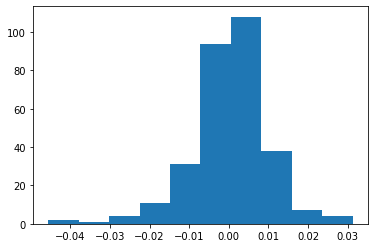

In [862]:
plt.hist(current_returns.iloc[:,0])

In [877]:
np.exp(np.linspace(start = np.log(0.1), stop = np.log(1e-3) ,num =50))

array([0.1       , 0.09102982, 0.08286428, 0.0754312 , 0.06866488,
       0.06250552, 0.05689866, 0.05179475, 0.04714866, 0.04291934,
       0.0390694 , 0.0355648 , 0.03237458, 0.02947052, 0.02682696,
       0.02442053, 0.02222996, 0.0202359 , 0.0184207 , 0.01676833,
       0.01526418, 0.01389495, 0.01264855, 0.01151395, 0.01048113,
       0.00954095, 0.00868511, 0.00790604, 0.00719686, 0.00655129,
       0.00596362, 0.00542868, 0.00494171, 0.00449843, 0.00409492,
       0.00372759, 0.00339322, 0.00308884, 0.00281177, 0.00255955,
       0.00232995, 0.00212095, 0.0019307 , 0.00175751, 0.00159986,
       0.00145635, 0.00132571, 0.00120679, 0.00109854, 0.001     ])

In [876]:
  x = np.dot(X_npn, np.ones(X.shape[1])/X.shape[1])
  level = 0
  ecdf = ECDF(1000*x)
  numerator = integrate.quad(lambda x: 1-ecdf(x), level, np.inf, limit = 10000)
  denominator = integrate.quad(ecdf, -np.inf, level, limit = 10000)
  denominator

(0.014633813469468663, 1.4876529077812523e-08)

# LGMRF test

In [91]:
X = np.array(current_returns)
out_heavy_no_constraint = fingraph.learn_regular_heavytail_graph(X, heavy_type = "student", nu = 4, verbose = False)
out_heavy_no_constraint = dict(zip(out_heavy_no_constraint.names, list(out_heavy_no_constraint)))
precision_matrix =out_heavy_no_constraint['laplacian']

In [154]:

precision_matrix

array([[ 1.00009994, -0.01536907, -0.01495169, ..., -0.01518425,
        -0.01522553, -0.01509827],
       [-0.01536907,  1.00009997, -0.0152619 , ..., -0.01580301,
        -0.01516547, -0.01498821],
       [-0.01495169, -0.0152619 ,  1.00009996, ..., -0.0150602 ,
        -0.01501134, -0.01514713],
       ...,
       [-0.01518425, -0.01580301, -0.0150602 , ...,  1.00009998,
        -0.01487211, -0.01492325],
       [-0.01522553, -0.01516547, -0.01501134, ..., -0.01487211,
         1.00009998, -0.01561482],
       [-0.01509827, -0.01498821, -0.01514713, ..., -0.01492325,
        -0.01561482,  1.00009997]])

In [155]:
l,u = np.linalg.eigh(precision_matrix)

new_prec = precision_matrix + 0.001*np.identity(precision_matrix.shape[0])#np.ones(precision_matrix.shape)/precision_matrix.shape[0]#np.dot(u[:,3:], np.diag(l[3:])).dot(u[:,3:].T)
np.dot(new_prec, np.ones(S.shape[0]))/np.dot(np.ones(S.shape[0]), new_prec).dot(np.ones(S.shape[0]))


array([0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537])

# huge test

In [388]:
X.shape

(150, 68)

In [733]:
out = huge.huge(X, method = 'glasso', nlambda = 30,verbose = False,lambda_min_ratio = 0.02)
out_select = huge.huge_select(out, criterion = "ebic",ebic_gamma = 0.5   )
out_select = dict(zip(out_select.names, list(out_select)))

Conducting extended Bayesian information criterion (ebic) selection....done


In [758]:
out_select['sparsity'][21]

0.3283582089552239

In [746]:
opt_index = int(np.where(out_select['opt.lambda'][0] == out_select['lambda'])[0][0])

0.3143374038896427

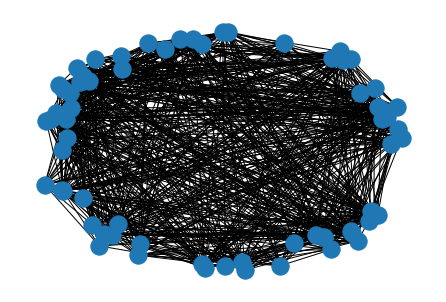

In [740]:
ok = out_select['opt.icov'].copy()
np.fill_diagonal(ok,0)
G = nx.from_numpy_array(ok)
nx.draw(G)
nx.density(G)

0.31614654002713705

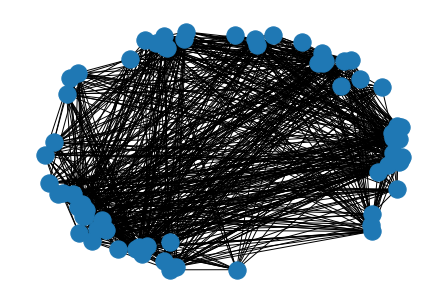

In [749]:
ok = out_select['icov'][opt_index-1].copy()
np.fill_diagonal(ok,0)
G = nx.from_numpy_array(ok)
nx.draw(G)
nx.density(G)

# sklearn glasso

c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


array([-9497.79000667, -5672.67667884, -3902.94917592, -1850.46869785,
       -1480.05407468, -1116.19616615,  -797.53669138,  -493.33256637,
          46.1388955 ,   306.93429541,   655.08454244,  1307.29924656,
        1776.51585994,  1819.13072536,  2113.12217376,  2425.87175987,
        2801.11524297,  3378.19006706,  3596.06281377,  4585.53843523])

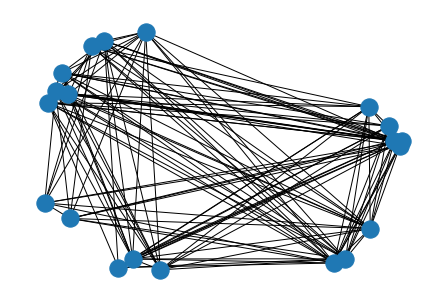

In [350]:
from sklearn.covariance import GraphicalLassoCV
glasso = GraphicalLassoCV(cv = 3).fit(X[:, :20])

ok = glasso.precision_
np.fill_diagonal(ok,0)

nx.draw(nx.from_numpy_array(ok))
l,u = np.linalg.eigh(ok)
l


In [353]:
np.linalg.inv(np.cov(X.T))

array([[33296.54488788,   130.1576352 ,   556.0730679 , ...,
         5024.81927868,  -403.3110298 ,  -702.31223895],
       [  130.1576352 , 21652.80452904, -1702.82786107, ...,
        -2948.24444134, -1182.37042   ,  1515.92449253],
       [  556.0730679 , -1702.82786107, 19018.62701822, ...,
         1241.1691842 ,  -966.59118403, -1193.54552925],
       ...,
       [ 5024.81927868, -2948.24444134,  1241.1691842 , ...,
        19858.81316626,  1358.82496798,   -85.80945303],
       [ -403.3110298 , -1182.37042   ,  -966.59118403, ...,
         1358.82496798, 16919.18151784, -1701.24887848],
       [ -702.31223895,  1515.92449253, -1193.54552925, ...,
          -85.80945303, -1701.24887848, 10023.60085854]])

In [251]:
glasso.cv_results_

c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:88: FutureWarning: Key: 'split0_score', is deprecated in 1.0 and will be removed in 1.2. Use 'split0_test_score' instead
  warnings.warn(
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:88: FutureWarning: Key: 'split1_score', is deprecated in 1.0 and will be removed in 1.2. Use 'split1_test_score' instead
  warnings.warn(
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:88: FutureWarning: Key: 'split2_score', is deprecated in 1.0 and will be removed in 1.2. Use 'split2_test_score' instead
  warnings.warn(
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:88: FutureWarning: Key: 'mean_score', is deprecated in 1.0 and will be removed in 1.2. Use 'mean_test_score' instead
  warnings.warn(
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.

{'alphas': array([4.51964974e-04, 9.73729020e-05, 7.16316211e-05, 5.26952473e-05,
        3.87648505e-05, 2.85170620e-05, 2.68187242e-05, 2.52215311e-05,
        2.37194590e-05, 2.23068431e-05, 2.20345802e-05, 2.17656402e-05,
        2.14999828e-05, 2.12375679e-05, 2.09783558e-05, 4.51964974e-06,
        0.00000000e+00]),
 'split0_test_score': array([56.09079256, 59.40679569, 60.81377733, 61.54487643, 61.93829646,
        62.16071445, 62.1904642 , 62.21644787, 62.23847607, 62.25694212,
        62.26024062, 62.26341358, 62.26646318, 62.26939069,        -inf,
               -inf, 61.42955913]),
 'split0_score': array([56.09079256, 59.40679569, 60.81377733, 61.54487643, 61.93829646,
        62.16071445, 62.1904642 , 62.21644787, 62.23847607, 62.25694212,
        62.26024062, 62.26341358, 62.26646318, 62.26939069,        -inf,
               -inf, 61.42955913]),
 'split1_test_score': array([57.84266543, 60.52443283, 61.38003725, 62.01249151, 62.43385801,
        62.70356454, 62.74274605, 6

# GGLasso


In [229]:
from gglasso.problem import glasso_problem
P = glasso_problem(np.cov(X.T), X.shape[0], reg_params = {'lambda1': 0.05}, latent = False, do_scaling = False)

In [235]:
lambda1_range = np.logspace(0, -3, 30)
modelselect_params = {'lambda1_range': lambda1_range}

P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.1)
P.solution.precision_

array([[10712.72339524,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,  6828.87183737,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,  4521.98943156, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
         6557.7521005 ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,  6412.8475339 ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,  3884.60172106]])

In [236]:
P.solution.precision_

array([[10712.72339524,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,  6828.87183737,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,  4521.98943156, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
         6557.7521005 ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,  6412.8475339 ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,  3884.60172106]])

In [237]:
from gglasso.helper.data_generation import generate_precision_matrix, group_power_network, sample_covariance_matrix
from gglasso.problem import glasso_problem
from gglasso.helper.basic_linalg import adjacency_matrix

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

p = 20
N = 1000

Sigma, Theta = generate_precision_matrix(p=p, M=1, style='erdos', prob=0.1, seed=1234)

S, sample = sample_covariance_matrix(Sigma, N)

print("Shape of empirical covariance matrix: ", S.shape)
print("Shape of the sample array: ", sample.shape)

Shape of empirical covariance matrix:  (20, 20)
Shape of the sample array:  (20, 1000)


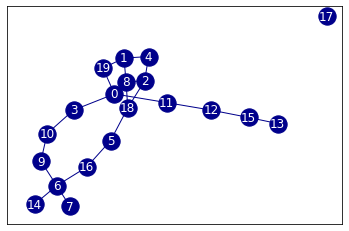

In [238]:
A = adjacency_matrix(Theta)

G = nx.from_numpy_array(A)
pos = nx.drawing.layout.spring_layout(G, seed = 1234)

plt.figure()
nx.draw_networkx(G, pos = pos, node_color = "darkblue", edge_color = "darkblue", font_color = 'white', with_labels = True)

In [239]:
P = glasso_problem(S, N, reg_params = {'lambda1': 0.05}, latent = False, do_scaling = False)
print(P)

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}


In [240]:
lambda1_range = np.logspace(0, -3, 30)
modelselect_params = {'lambda1_range': lambda1_range}

P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.1)

# regularization parameters are set to the best ones found during model selection
print(P.reg_params)

ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated 

In [241]:
np.linalg.eigh(P.solution.precision_)

(array([0.35032749, 0.51360373, 0.59866797, 0.63364128, 0.84550003,
        0.86330357, 0.88314453, 0.88477144, 0.92308544, 0.97858934,
        0.99189372, 1.02415215, 1.03237539, 1.04370464, 1.11608856,
        1.13912686, 1.33345918, 1.34835067, 1.36309521, 1.44802635]),
 array([[-2.82478716e-03,  2.28333233e-02, -3.28402389e-01,
         -1.49939687e-02,  5.44356253e-01,  1.64315323e-03,
          1.90616186e-01,  1.40512848e-02, -7.47372649e-04,
          1.86486786e-02,  6.81066658e-05, -2.37763805e-05,
          4.74944939e-17,  5.15566535e-04,  6.27413243e-01,
         -1.55048941e-01,  8.74852258e-03, -3.09658490e-01,
         -2.10926236e-01, -6.95450272e-03],
        [-3.22264735e-03,  2.49950078e-01, -1.49287723e-01,
          6.18605373e-01, -7.79739578e-02, -1.76512678e-04,
         -7.79239221e-02, -4.83070286e-03,  2.69941215e-04,
         -2.34602108e-01,  3.28218202e-04, -1.09987010e-02,
          2.17047303e-17, -4.30198603e-05, -5.65737433e-02,
         -1.56519691e-

# asdf

In [441]:
with open(f'../data/Graphs/case_study_1_d_1_winlen_300_gest_huge_glasso_ebic_scale_None.pkl', 'rb') as f:
    data_dict = pickle.load(f)
data_dict[0].keys()

dict_keys(['dates', 'graph_dict', 'sector', 'cov_dict', 'GMV_portfolio_dict', 'max_sharpe_portfolio_dict', 'return_dict', 'window_size', 'stock_partition', 'gmv_div_dict', 'gmv_var_div_dict', 'sharpe_div_dict', 'sharpe_var_div_dict', 'uni_div_dict', 'uni_var_div_dict', 'cov_dict2', 'GMV_portfolio_dict2', 'max_sharpe_portfolio_dict2', 'return_dict2', 'gmv_div_dict2', 'gmv_var_div_dict2', 'sharpe_div_dict2', 'sharpe_var_div_dict2', 'uni_div_dict2', 'uni_var_div_dict2'])

In [447]:
data_dict[0]['max_sharpe_portfolio_dict'][0][0]

array([ -5.56758164,  -0.77659614,   3.3621589 ,  -1.54456253,
       -23.69649873,  -6.97204964,   2.25920047,  -1.30675267,
         5.80657684, -17.15734765,  -0.21540404,   7.38025357,
         7.75586011,  19.91582093,   0.76772217,   1.09881244,
        -0.73068965,  11.71869464,   9.05905117, -10.15666852])

In [450]:
S = data_dict[0]['cov_dict'][0][0]
precision_matrix = np.linalg.inv(S)
mu = data_dict[0]['return_dict'][0][0]
w_sharpe = np.dot(precision_matrix, mu)/np.dot(np.ones(S.shape[0]), precision_matrix).dot(mu)
w_sharpe


array([ -5.56758164,  -0.77659614,   3.3621589 ,  -1.54456253,
       -23.69649873,  -6.97204964,   2.25920047,  -1.30675267,
         5.80657684, -17.15734765,  -0.21540404,   7.38025357,
         7.75586011,  19.91582093,   0.76772217,   1.09881244,
        -0.73068965,  11.71869464,   9.05905117, -10.15666852])

is it correct?

In [604]:
rolling_window_size = 300
time_i = 300
assets = data_dict[0]['stock_partition'][0][0]
current_returns = return_pivot.loc[:,np.isin(return_pivot.columns,assets)].iloc[(time_i - rolling_window_size):time_i]
current_returns = current_returns.iloc[:,:]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
current_return_scaled = scaler.fit_transform(current_returns)

X = np.array(current_returns)
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#out_heavy_no_constraint = fingraph.learn_regular_heavytail_graph(X, heavy_type = "student", nu = 4, verbose = False)
#out_heavy_no_constraint = dict(zip(out_heavy_no_constraint.names, list(out_heavy_no_constraint)))
#precision_matrix =out_heavy_no_constraint['laplacian']
#precision_matrix = precision_matrix + 0.0001*np.identity(precision_matrix.shape[0])
#S = np.linalg.inv(precision_matrix)

out = huge.huge(np.cov(X.T), method = 'glasso', nlambda = 30,verbose = False)
out_select = huge.huge_select(out, criterion = "ebic", stars_thresh = 0.1, rep_num = 10,ebic_gamma = 0.5 )
out_select = dict(zip(out_select.names, list(out_select)))
precision_matrix = out_select['opt.icov'].copy()
S = np.linalg.inv(precision_matrix)

mu = current_returns.mean()

# GMV diversification
w_gmv = np.dot(precision_matrix, np.ones(S.shape[0]))/np.dot(np.ones(S.shape[0]), precision_matrix).dot(np.ones(S.shape[0])) 
# SHARPE
w_sharpe = np.dot(precision_matrix, mu)/np.dot(np.ones(S.shape[0]), precision_matrix).dot(mu)
w_sharpe

Model selection is not available when using the covariance matrix as input.

KeyError: 'opt.icov'

In [588]:
np.sum(w_sharpe[w_sharpe <0]) <-0.3

False

In [703]:
def fix_weight(w:np.array):

    if np.sum(w[w <0]) <-0.3:

        # fix negative
        w[w <0] = 0.3*w[w <0]/np.abs(np.sum(w[w <0]))
        w[w >=0] = 1.3*w[w >=0]/np.abs(np.sum(w[w >=0]))

    return w


In [704]:
w_new = fix_weight(w_sharpe)
np.sum(w_new)

1.0000000000000004

In [702]:
X

array([[-0.00076647,  0.00146627, -0.0071986 , ...,  0.00091197,
         0.        , -0.00979343],
       [-0.000511  ,  0.00018309,  0.00048167, ..., -0.00592962,
         0.01202942, -0.00249857],
       [ 0.00229779, -0.00477229, -0.01145835, ...,  0.00842758,
        -0.00012991,  0.00733823],
       ...,
       [ 0.00205601,  0.00467346,  0.01355426, ..., -0.00216407,
        -0.00691753,  0.00775609],
       [ 0.00568908,  0.        ,  0.00874976, ...,  0.00270452,
         0.02204863,  0.01934542],
       [-0.01118097, -0.01137383, -0.03546873, ..., -0.00677591,
        -0.02204863, -0.00991485]])

In [707]:
numerator[0]

0.004161780389268643

In [732]:
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.integrate as integrate
ecdf = ECDF(np.dot(X,w_new))

numerator = integrate.quad(lambda x: 1-ecdf(x), 0, np.inf, limit = 10000)
denominator = integrate.quad(ecdf, -np.inf, 0, limit = 10000)

omega_0 = numerator/denominator


TypeError: unsupported operand type(s) for /: 'tuple' and 'tuple'

In [491]:
denominator

(0.00301437657528685, 1.3879408592917808e-08)

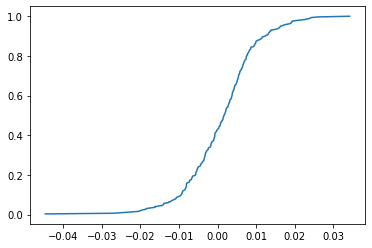

In [478]:
plt.plot(ecdf.x, ecdf.y)

In [481]:
ecdf([0,0.05])

array([0.42666667, 1.        ])

# Test sklearn and hugo

The input is identified as the covariance matrix.
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 100%
Conducting the graphical lasso (glasso)....done.                                          
[0.1]


array([[[ 1.46099210e+00, -1.71801938e-01, -0.00000000e+00,
         -0.00000000e+00, -5.45586772e-02, -4.73665226e-02,
         -1.50530975e-01, -6.01154638e-01, -0.00000000e+00,
         -6.24272462e-02, -0.00000000e+00, -0.00000000e+00,
         -6.34798197e-03, -1.47872593e-02, -0.00000000e+00,
         -3.00456284e-02, -4.78210615e-02, -0.00000000e+00,
         -2.76686867e-02, -0.00000000e+00],
        [-1.71759064e-01,  1.83106020e+00, -2.00755660e-01,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -7.34670205e-01, -4.73031984e-02, -1.48178894e-01,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -6.04660708e-02, -0.00000000e+00, -9.45238345e-02,
         -1.26808867e-01, -1.13776922e-01, -3.07699448e-02,
         -0.00000000e+00, -3.77772402e-02],
        [-0.00000000e+00, -2.00768931e-01,  1.39859802e+00,
         -2.12728985e-02, -1.49784921e-02, -7.68567387e-02,
         -1.98009308e-01, -1.28342952e-01, -3.50190181e-03,
         -0.

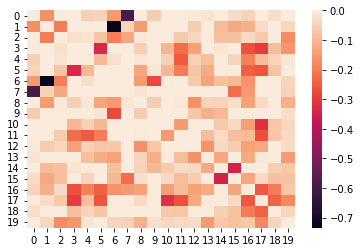

In [603]:
out = huge.huge(np.corrcoef(X.T), 0.1, method = 'glasso',scr = False)
out = dict(zip(out.names, list(out)))
print(out['lambda'])
#out_select = huge.huge_select(out, criterion = "ebic",ebic_gamma = 0.5   )
#out_select = dict(zip(out_select.names, list(out_select)))

ok = np.array(out['icov'][0])
np.fill_diagonal(ok, 0)
sns.heatmap(ok)
np.array(out['icov'])

In [606]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(X)

out_sklearn2 = GraphicalLassoCV().fit(X)
out_sklearn2.precision_

c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


array([[ 1.08455392e+04, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -2.62140544e+02, -7.21199712e+02, -0.00000000e+00,
        -0.00000000e+00, -2.06559393e+02, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00,  1.06837186e+04, -7.67882577e+02,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -2.64960085e+03, -0.00000000e+00, -3.37827178e+02,
        -0.00000000e+00, -4.07961810e+02, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -1.32293215e+01,
        -3.69253532e+02, -4.50411675e+01, -1.92531108e+02,
        -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -7.67882577e+02,  6.24595888e+03,
        -2.00426248e+02, -0.00000000e+00, -2.83610054e+02,
        -9.50133789e+02, -1.35422663e+02, -6.76189229e+01,
        -0.00000000e+00, -0.0

In [607]:
out_sklearn = graphical_lasso(np.corrcoef(X.T),alpha = 0.1, mode = 'cd')
out_sklearn[1]

array([[ 1.77172946, -0.22430978, -0.        , -0.        , -0.0635444 ,
        -0.04461222, -0.18357607, -0.82073006, -0.        , -0.06449374,
        -0.        , -0.        , -0.        , -0.00529894, -0.        ,
        -0.01290957, -0.05479672, -0.        , -0.02193544, -0.        ],
       [-0.22430978,  2.35805101, -0.25600503, -0.        , -0.        ,
        -0.        , -1.09943224, -0.02642517, -0.18189671, -0.        ,
        -0.        , -0.        , -0.06259799, -0.        , -0.10365209,
        -0.16405794, -0.13885047, -0.0067961 , -0.        , -0.03427764],
       [-0.        , -0.25600503,  1.64496168, -0.00601636, -0.01118342,
        -0.08743372, -0.24708171, -0.15289559, -0.        , -0.        ,
        -0.        , -0.07705014, -0.04582967, -0.        , -0.09880825,
        -0.09948342, -0.03423863, -0.08295473, -0.        , -0.22737027],
       [-0.        , -0.        , -0.00601636,  2.249439  , -0.        ,
        -0.4601609 , -0.        , -0.        , -

In [507]:
out = huge.huge(X, method = 'glasso', nlambda = 30,verbose = False)
out_select = huge.huge_select(out, criterion = "ebic", stars_thresh = 0.1, rep_num = 10,ebic_gamma = 0.5 )
out_select = dict(zip(out_select.names, list(out_select)))
# precision_matrix = out_select['opt.icov'].copy()
# S = np.linalg.inv(precision_matrix)
out_select['icov']

Conducting extended Bayesian information criterion (ebic) selection....done


<rpy2.robjects.vectors.ListVector object at 0x000001D2CE9EB080> [RTYPES.VECSXP]
R classes: ('list',)
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp...]
  <no name>: <class 'numpy.ndarray'>
  array([[0.55112807, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.55112807, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.55112807, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.55112807, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.55112807,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.55112807, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.55112807, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.55112807, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.55112807, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.55112807,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.55112807, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.55112807, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.55112807, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.55112807, 0

# My hugo

In [822]:
robjects.r('''

library(huge)

huge.glasso = function(x, lambda = NULL, lambda.min.ratio = NULL, nlambda = NULL, scr = NULL, cov.output = FALSE, verbose = TRUE){

  gcinfo(FALSE)
  n = nrow(x)
  d = ncol(x)
  cov.input = isSymmetric(x)
  if(cov.input)
  {
    if(verbose) cat("The input is identified as the covariance matrix.\n")
    S = x
  }
  else
  {
    print("my_method")
    S = cov(x)
  }
  rm(x)
  gc()
  if(is.null(scr)) scr = FALSE
  if(!is.null(lambda)) nlambda = length(lambda)
  if(is.null(lambda))
  {
    if(is.null(nlambda))
      nlambda = 10
    if(is.null(lambda.min.ratio))
      lambda.min.ratio = 0.1
    lambda.max = max(max(S-diag(d)),-min(S-diag(d)))
    lambda.min = lambda.min.ratio*lambda.max
    lambda = exp(seq(log(lambda.max), log(lambda.min), length = nlambda))
  }

  fit = .Call("_huge_hugeglasso",S,lambda,scr,verbose,cov.output,PACKAGE="huge")

  fit$scr = scr
  fit$lambda = lambda
  fit$cov.input = cov.input
  fit$cov.output = cov.output

  rm(S)
  gc()
  if(verbose){
       cat("\nConducting the graphical lasso (glasso)....done.                                          \r")
       cat("\n")
      flush.console()
  }
  return(fit)
}

huge = function(x, lambda = NULL, nlambda = NULL, lambda.min.ratio = NULL, method = "mb", scr = NULL, scr.num = NULL, cov.output = FALSE, sym = "or", verbose = TRUE)
{
	gcinfo(FALSE)
	est = list()
	est$method = method

	if(method == "ct")
	{
		fit = huge.ct(x, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, lambda = lambda, verbose = verbose)
		est$path = fit$path
		est$lambda = fit$lambda
		est$sparsity = fit$sparsity
		est$cov.input = fit$cov.input
		rm(fit)
		gc()
	}

	if(method == "mb")
	{
		fit = huge.mb(x, lambda = lambda, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, scr = scr, scr.num = scr.num, sym = sym, verbose = verbose)
		est$path = fit$path
		est$beta = fit$beta
		est$lambda = fit$lambda
		est$sparsity = fit$sparsity
		est$df = fit$df
		est$idx_mat = fit$idx_mat
		est$sym = sym
		est$scr = fit$scr
		est$cov.input = fit$cov.input
		rm(fit,sym)
		gc()
	}


	if(method == "glasso")
	{
		fit = huge.glasso(x, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, lambda = lambda, scr = scr, cov.output = cov.output, verbose = verbose)
		est$path = fit$path
		est$lambda = fit$lambda
		est$icov = fit$icov
		est$df = fit$df
		est$sparsity = fit$sparsity
		est$loglik = fit$loglik
		if(cov.output)
			est$cov = fit$cov
		est$cov.input = fit$cov.input
		est$cov.output = fit$cov.output
		est$scr = fit$scr
		rm(fit)
		gc()
	}

	if(method == "tiger")
	{
	  fit = huge.tiger(x, lambda = lambda, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, sym = sym, verbose = verbose)
	  est$path = fit$path
	  est$lambda = fit$lambda
	  est$sparsity = fit$sparsity
	  est$df = fit$df
	  est$idx_mat = fit$idx_mat
	  est$sym = sym
	  est$scr = fit$scr
	  est$cov.input = fit$cov.input
	  est$icov = fit$icov;
	  rm(fit,sym)
	  gc()
	}

	est$data = x

	rm(x,scr,lambda,lambda.min.ratio,nlambda,cov.output,verbose)
	gc()
	class(est) = "huge"
	return(est)
}

my_huge <- function(X, gamma = 0.1){

    out.glasso = huge(X, lambda = exp(seq(log(1e-5), log(1e-7), length = 30)), method = "glasso")
    return(huge.select(out.glasso, criterion = "ebic",ebic.gamma = 0.1 ))


}


''')

<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x000001D2E841FC40> [RTYPES.CLOSXP]
R classes: ('function',)

In [840]:
my_huge = robjects.globalenv["my_huge"]
out_select = my_huge(X, gamma = 0.01)
out_select = dict(zip(out_select.names, list(out_select)))

[1] "my_method"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 3%6%9%13%16%19%23%26%30%33%36%40%43%46%50%53%56%60%63%66%70%73%76%80%83%86%90%93%96%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


In [841]:
out_select.keys()

dict_keys(['method', 'path', 'lambda', 'icov', 'df', 'sparsity', 'loglik', 'cov.input', 'cov.output', 'scr', 'data', 'ebic.score', 'opt.index', 'refit', 'opt.icov', 'opt.lambda', 'opt.sparsity', 'criterion'])

In [842]:
type(int(np.where(out_select['opt.lambda'][0] == out_select['lambda'])[0][0]))

int

In [843]:
precision_matrix = out_select['opt.icov'].copy()
precision_matrix

array([[15916.21686681,    -0.        ,    -0.        , ...,
           -0.        ,    -0.        ,   -69.04022721],
       [   -0.        , 13129.60175936,  -282.06224506, ...,
        -1173.50102862,    -0.        ,    -0.        ],
       [   -0.        ,  -281.90624567, 10906.64767395, ...,
           -0.        ,  -242.08621   ,    -0.        ],
       ...,
       [   -0.        , -1173.51916192,    -0.        , ...,
        11432.8908519 ,    -0.        ,    -0.        ],
       [   -0.        ,    -0.        ,  -242.1685583 , ...,
           -0.        , 10283.44657355,  -526.63345583],
       [  -69.07869588,    -0.        ,    -0.        , ...,
           -0.        ,  -526.60394165,  6579.71306227]])

In [844]:
S = np.linalg.inv(precision_matrix)
S

array([[1.03344144e-04, 4.80044697e-05, 5.79364214e-05, ...,
        4.47700384e-05, 3.93414779e-05, 5.84762617e-05],
       [4.80073192e-05, 1.56433106e-04, 9.90411513e-05, ...,
        8.17314060e-05, 6.09543422e-05, 8.86464300e-05],
       [5.79572504e-05, 9.90691242e-05, 2.31171785e-04, ...,
        9.49057067e-05, 8.00653612e-05, 1.11942353e-04],
       ...,
       [4.47781962e-05, 8.17415682e-05, 9.48913195e-05, ...,
        1.62498227e-04, 5.73198225e-05, 8.30056194e-05],
       [3.93497291e-05, 6.09649070e-05, 8.00557037e-05, ...,
        5.73214717e-05, 1.65943376e-04, 8.62510595e-05],
       [5.84903559e-05, 8.86643054e-05, 1.11930539e-04, ...,
        8.30111035e-05, 8.62525964e-05, 2.67441777e-04]])

# Testing if ESG is ordered

In [8]:
# esg smoothed stock
gp_esg_stock = pd.read_pickle('../data/tidy/gp_esg_stock_data_frame.pkl')

In [50]:
esg_comparison_dict = {}

In [81]:
k = 'Consumer Cyclical'

if k == 'Global':
    global_assets = np.concatenate([sector_classification[k] for k in sector_classification.keys()])
    price_df = return_pivot.loc[:, np.isin(return_pivot.columns,global_assets)]
    esg_df = gp_esg_stock.loc[:, np.isin(gp_esg_stock.columns,global_assets)]
    all_stocks_in_sector = global_assets
else:
    price_df = return_pivot.loc[:, np.isin(return_pivot.columns,sector_classification[k])]
    esg_df = gp_esg_stock.loc[:, np.isin(gp_esg_stock.columns,sector_classification[k])]
    all_stocks_in_sector = sector_classification[k]
d = 1
window_size = 300
nr_splits = 3
graph_estimation = ''
#scale,
#transform
lamda = [0.1]

In [82]:


# information stored in dictionaries
stocks_considered= dict()
graph_dict = {i: [] for i in range(nr_splits)}
graph_dict2 = {i: [] for i in range(nr_splits)}
return_dict  = {i: [] for i in range(nr_splits)}
esg_mean = {i: [] for i in range(nr_splits)}
esg_std = {i: [] for i in range(nr_splits)}
esg_max = {i: [] for i in range(nr_splits)}
esg_min = {i: [] for i in range(nr_splits)}
cov_dict = {i: [] for i in range(nr_splits)}
prec_dict = {i: [] for i in range(nr_splits)}
prec_dict_plus_1 = {i: [] for i in range(nr_splits)}
prec_dict_minus_1 = {i: [] for i in range(nr_splits)}
opt_lambda = {i: [] for i in range(nr_splits)}
reg_lambda = {i: [] for i in range(nr_splits)}
graph_covdict = {i: [] for i in range(nr_splits)}
where_opt_dict = {i: [] for i in range(nr_splits)}
where_opt_lambda_dict = {i: [] for i in range(nr_splits)}

portfolios_info = {}
portfolios_reg_info = {}

for port_type in ['uniform', 'sharpe', 'gmv']:
  portfolios_info[port_type] = {}
  portfolios_info[port_type]['weights'] = {i: [] for i in range(nr_splits)}
  portfolios_info[port_type]['cov_div'] = {i: [] for i in range(nr_splits)}
  portfolios_info[port_type]['var_div'] = {i: [] for i in range(nr_splits)}
  portfolios_info[port_type]['omega'] = {i: [] for i in range(nr_splits)}
  portfolios_info[port_type]['sharpe'] = {i: [] for i in range(nr_splits)}
  portfolios_info[port_type]['sortino'] = {i: [] for i in range(nr_splits)}
  portfolios_info[port_type]['beta'] = {i: [] for i in range(nr_splits)}
  portfolios_info[port_type]['treynor'] = {i: [] for i in range(nr_splits)}
  portfolios_info[port_type]['max_draw'] = {i: [] for i in range(nr_splits)}

nlambda = len(lamda)
reg_interval = np.concatenate((np.arange(0, nlambda, 10), [nlambda-1]))
for port_type in ['uniform', 'sharpe', 'gmv']:
  portfolios_reg_info[port_type] = {}
  for j in reg_interval:
    j = int(j)
    portfolios_reg_info[port_type][j] = {}
    portfolios_reg_info[port_type][j]['weights'] = {i: [] for i in range(nr_splits)}
    portfolios_reg_info[port_type][j]['cov_div'] = {i: [] for i in range(nr_splits)}
    portfolios_reg_info[port_type][j]['var_div'] = {i: [] for i in range(nr_splits)}
    portfolios_reg_info[port_type][j]['omega'] = {i: [] for i in range(nr_splits)}
    portfolios_reg_info[port_type][j]['sharpe'] = {i: [] for i in range(nr_splits)}
    portfolios_reg_info[port_type][j]['sortino'] = {i: [] for i in range(nr_splits)}
    portfolios_reg_info[port_type][j]['beta'] = {i: [] for i in range(nr_splits)}
    portfolios_reg_info[port_type][j]['treynor'] = {i: [] for i in range(nr_splits)}
    portfolios_reg_info[port_type][j]['max_draw'] = {i: [] for i in range(nr_splits)}


  # determine which stocks in the sector will be considered.
  # If the total number of stocks in the sector are not divisible by nr_splits
  # then the first stocks which correspond to the reminder of the division will be omitted
  # in future iterations only the stocks in stocks_considered will be used
  stocks_in_sector = price_df.columns[np.isin(price_df.columns,all_stocks_in_sector)]
  esg_stocks_in_sector = esg_df.columns[np.isin(esg_df.columns,all_stocks_in_sector)]

  stocks_considered[k] = stocks_in_sector.intersection(esg_stocks_in_sector)
  print(f'{k} has {len(stocks_considered[k])} stocks')
  

  if len(stocks_considered[k]) % nr_splits != 0:
    res = len(stocks_considered[k]) % nr_splits
    print(f'{k} dropped {stocks_considered[k][:res]}')
    stocks_considered[k] = stocks_considered[k][res:]
    


stock_partition = {i: [] for i in range(nr_splits)}

dates4 = []
min_max_date = np.min([np.max(price_df.index), np.max(esg_df.index)])
price_df=price_df.loc[price_df.index <= min_max_date]
for i in tqdm.tqdm(range(window_size, price_df.shape[0], 2)): #price_df.shape[0]
    

  # get esg scores of the stocks for the current iteration
  esg_i = np.array(esg_df[stocks_considered[k]].loc[esg_df.index == price_df.index[i]].iloc[0,:])

  # get snp500 index for current iteration, used in  
  # snp500_i = np.array(sp500.loc[np.isin(sp500.date,return_pivot.iloc[(i-window_size):i].index), 'log_return'])
  # order stocks
  stocks_ordered_i = np.array(stocks_considered[k][np.argsort(esg_i)])
  # get date of the iteration i
  date_i = price_df.index[i]


  # Store date
  dates4.append(date_i)
  # create a dummy index so we can access the correct stocke later on
  stocks_indexes = np.array(range(len(stocks_considered[k])))
  # this for loop consideres each split and fetches the correct stocks for the split
  for i_split, stocks_index in enumerate(np.array_split(stocks_indexes, nr_splits)):
    esg_split_i_max = esg_df[stocks_ordered_i[stocks_index]].loc[esg_df.index == price_df.index[i]].max(axis = 1)[0]
    esg_max[i_split].append(esg_split_i_max)
    esg_split_i_min = esg_df[stocks_ordered_i[stocks_index]].loc[esg_df.index == price_df.index[i]].min(axis = 1)[0]
    esg_min[i_split].append(esg_split_i_min)
    esg_split_i_mean = esg_df[stocks_ordered_i[stocks_index]].loc[esg_df.index == price_df.index[i]].mean(axis = 1)[0]
    esg_mean[i_split].append(esg_split_i_mean)
    esg_split_i_std = esg_df[stocks_ordered_i[stocks_index]].loc[esg_df.index == price_df.index[i]].std(axis = 1)[0]
    esg_std[i_split].append(esg_split_i_std)
    esg_split_i_max = esg_df[stocks_ordered_i[stocks_index]].loc[esg_df.index == price_df.index[i]].max(axis = 1)[0]
    esg_max[i_split].append(esg_split_i_max)
    esg_split_i_min = esg_df[stocks_ordered_i[stocks_index]].loc[esg_df.index == price_df.index[i]].min(axis = 1)[0]
    esg_min[i_split].append(esg_split_i_min)



esg_comparison_dict[k] =   (np.array(esg_mean[2]) - 1.96 * np.array(esg_std[2])) - (np.array(esg_mean[0]) + 1.96 * np.array(esg_std[0]))

Consumer Cyclical has 56 stocks
Consumer Cyclical dropped Index(['BWA', 'GM'], dtype='object')
Consumer Cyclical has 56 stocks
Consumer Cyclical dropped Index(['BWA', 'GM'], dtype='object')
Consumer Cyclical has 56 stocks
Consumer Cyclical dropped Index(['BWA', 'GM'], dtype='object')


100%|██████████| 784/784 [00:13<00:00, 58.21it/s]


In [85]:
esg_comparison_pd = pd.DataFrame(esg_comparison_dict, index = dates4)

In [91]:
with open("../data/esg_portfolio_diff.pkl", "wb") as f:
    pickle.dump(esg_comparison_pd, f)

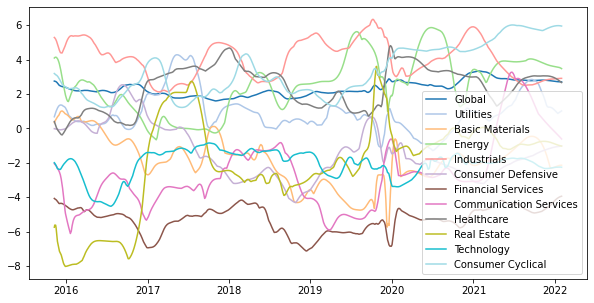

In [90]:

from matplotlib import cm
start = 0.0
stop = 1.0
number_of_lines= 12
cm_subsection = np.linspace(start, stop, number_of_lines) 
colors = [ cm.tab20(x) for x in cm_subsection ]

fig,ax = plt.subplots(1,1, figsize = (10,5))
for i, k in enumerate(esg_comparison_pd.columns):
    ax.plot(esg_comparison_pd.index, esg_comparison_pd[k], color = colors[i], label = k)
ax.legend()

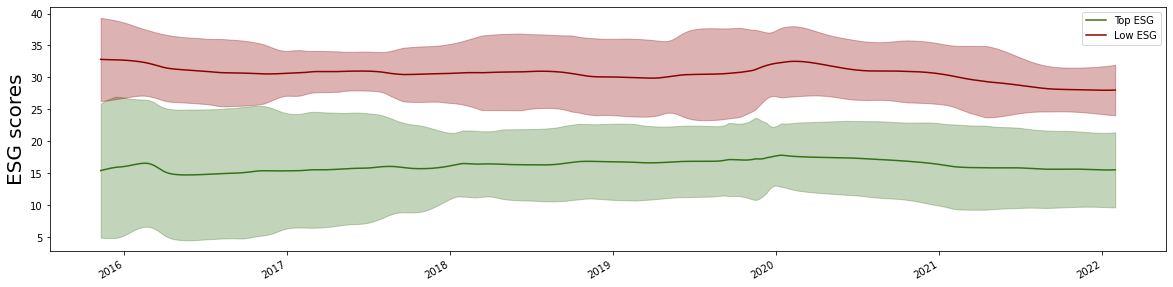

In [11]:
color_dark = np.array(["#35711b", "#D18700" ,"#8B0000"])
color_light = np.array(["#39e75f", "#FFC55C" ,"#FF7276"])
legend_titles = np.array(['Top ESG', 'Medium ESG', 'Low ESG'])

fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(dates4, esg_mean[0], color = color_dark[0])
ax.plot(dates4, esg_mean[2], color = color_dark[2])
ax.fill_between(
    np.array(dates4).ravel(),
    np.array(esg_mean[0]) - 1.96 * np.array(esg_std[0]),
    np.array(esg_mean[0]) + 1.96 * np.array(esg_std[0]),
    alpha=0.3,
    color = color_dark[0]
)

# ax.plot(scale_F_nonparanormal['dates'], scale_F_nonparanormal['esg_mean'][1], color = color_dark[1])
# ax.fill_between(
#     scale_F_nonparanormal['dates'].ravel(),
#     np.array(scale_F_nonparanormal['esg_mean'][1]) - 1.96 * np.array(scale_F_nonparanormal['esg_std'][1]),
#     np.array(scale_F_nonparanormal['esg_mean'][1]) + 1.96 * np.array(scale_F_nonparanormal['esg_std'][1]),
#     alpha=0.3,
#     color = color_dark[1]
# )

ax.fill_between(
    np.array(dates4).ravel(),
    np.array(esg_mean[2]) - 1.96 * np.array(esg_std[2]),
    np.array(esg_mean[2]) + 1.96 * np.array(esg_std[2]),
    alpha=0.3,
    color = color_dark[2]
)

ax.set_ylabel('ESG scores',fontdict={'fontsize':20,})


ax.tick_params( labelsize=10)
ax.legend(['Top ESG', 'Low ESG'])

fig.autofmt_xdate()

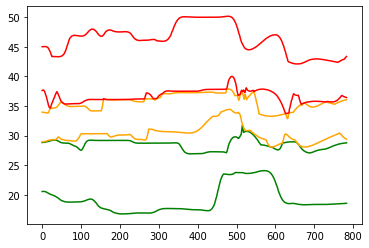

In [87]:
plt.plot(esg_max[0], color = 'green')
plt.plot(esg_min[0], color = 'green')
plt.plot(esg_max[1], color = 'orange')
plt.plot(esg_min[1], color = 'orange')
plt.plot(esg_max[2], color = 'red')
plt.plot(esg_min[2], color = 'red')